## Global Macro Dashboard

An overview of some important indicators of the global economy's health.

### Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import quandl

import pandas_datareader.data as web
import xlrd as xls
import datetime
import missingno as msno

import os
import sys
import shutil
from pathlib import Path

from IPython.core.display import HTML

%matplotlib inline
plt.close('all')

import nbconvert
html_css_files = ['https://cdn.jupyter.org/notebook/5.1.0/style/style.min.css']

quandl_token = 'e4FyZJfz6ukboUWG4Pm_' # hide?

In [3]:
# Setting dates for plotting
# set now to current time and date
now = datetime.datetime.now()
# set a start date in the past
start = datetime.datetime(2008, 1, 1)
# other start/end options: 
# start = '20080101'
# end = ''
today = datetime.datetime(now.year, now.month, now.day)

**Refactor code:**
- after library import have one section for raw data download; save raw data as CSVs
- add try/except in case download / API fails - have fallback to old CSV 
- next section: clean raw data, then save cleaned data as CSVs
- use cleaned CSV files to do analysis, plot etc

### US Treasury bond yields

#### Load data US treasury bond yields

In [4]:
# load from Quandl API & save copy locally to CSV file
try:
    UST_download = quandl.get("USTREASURY/YIELD", authtoken=quandl_token)
    UST_download.to_csv("data/US_treasury_yields.csv")
except:
    print("Problem with Quandl API")

In [5]:
# load CSV into pandas DF and replace index column with date column
US_treasury_yields = pd.read_csv("data/US_treasury_yields.csv", parse_dates=['Date'])
US_treasury_yields.set_index(['Date'], drop=True, inplace=True)

#### Load US data on GDP, inflation etc from FRED

In [6]:
US_GDP = web.DataReader('GDP', 'fred')
US_GDP.to_csv("data/US_GDP.csv")
US_inflation = web.DataReader(['CPIAUCSL', 'CPILFESL'], 'fred')
US_inflation.to_csv("data/US_inflation.csv")

# FRED also has Treasury yield data available, but there seem to be more missing
# values compared to quandl, so using Quandl as above
# UST_3m_FRED = web.DataReader(['T10Y3MM'], 'fred', start, end)
# UST_2y_FRED = web.DataReader(['T10Y2Y'], 'fred', start, end)

#### Load data for copper / gold ratio from Quandl

**Comment: Also add front-month contracts**

In [7]:
# load from Quandl API & save copy locally to CSV file
try:
    copper_download = quandl.get("CHRIS/CME_HG2", authtoken=quandl_token)
    gold_download = quandl.get("CHRIS/CME_GC2", authtoken=quandl_token)
    copper_download.to_csv("data/copper_2nd.csv")
    gold_download.to_csv("data/gold_2nd.csv")
except:
    print("Problem with Quandl API")

In [8]:
# load CSV into pandas DF
copper_2nd_cont = pd.read_csv("data/copper_2nd.csv", parse_dates=['Date'])
gold_2nd_cont = pd.read_csv("data/gold_2nd.csv", parse_dates=['Date'])
# replace index column with datetime
copper_2nd_cont.set_index(['Date'], drop=True, inplace=True)
gold_2nd_cont.set_index(['Date'], drop=True, inplace=True)

In [9]:
copper_settle = copper_2nd_cont["Settle"]
copper_settle.tail()

Date
2019-03-18    2.9075
2019-03-19    2.9210
2019-03-20    2.9180
2019-03-21    2.9025
2019-03-22    2.8380
Name: Settle, dtype: float64

In [10]:
gold_settle = gold_2nd_cont["Settle"]
gold_settle.tail()

Date
2019-03-18    1301.5
2019-03-19    1306.5
2019-03-20    1301.7
2019-03-21    1307.3
2019-03-22    1312.3
Name: Settle, dtype: float64

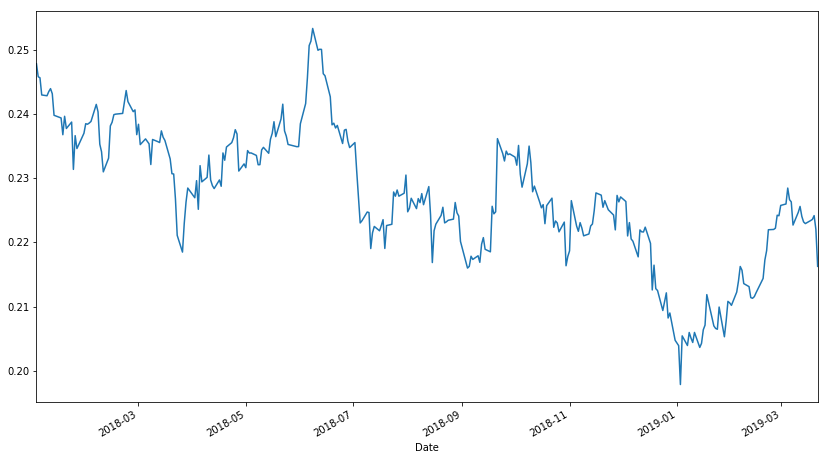

In [11]:
# set date range (specific to this ratio)
start_cu_au = datetime.datetime(2018, 1, 1)

copper_gold = pd.concat([copper_settle, gold_settle], axis=1)
column_rename = copper_gold.columns.values
column_rename[0] = 'Copper'
column_rename[1] = 'Gold'
copper_gold.columns = column_rename
cu_au_ratio = (copper_gold["Copper"] * 100 / copper_gold["Gold"])
cu_au_ratio.loc[start_cu_au:].plot(figsize=(14, 8))
plt.show()

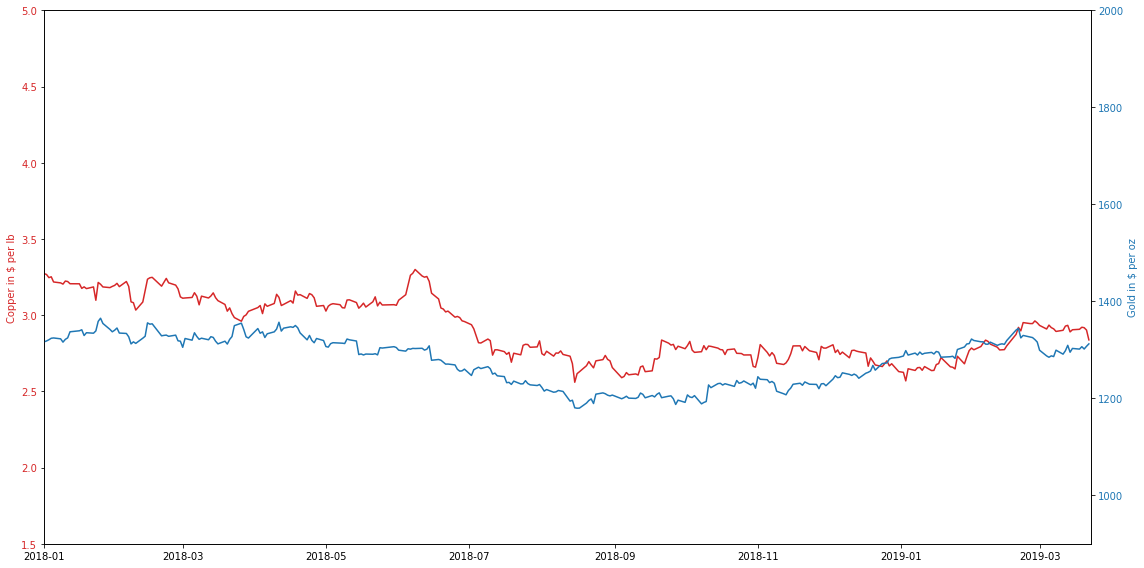

In [12]:
fig, ax1 = plt.subplots(figsize=(16,8))
color = 'tab:red'
ax1.xaxis_date()
ax1.set_xlim([start_cu_au, now])
ax1.set_ylim([1.5, 5])  ## THIS NEEDS TO BE ADAPTED / autoscaled

ax1.set_ylabel('Copper in $ per lb', color=color)
ax1.plot(copper_settle, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
ax2.set_ylim([900, 2000])  ## THIS NEEDS TO BE ADAPTED / autoscaled
color = 'tab:blue'
ax2.set_ylabel('Gold in $ per oz', color=color)
ax2.plot(gold_settle, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [13]:
US_treasury_yields.tail()

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
2019-03-18,2.47,2.46,2.44,2.51,2.52,2.45,2.41,2.42,2.51,2.60,2.83,3.01
2019-03-19,2.46,2.47,2.46,2.52,2.50,2.46,2.42,2.42,2.51,2.61,2.84,3.02
2019-03-20,2.45,2.45,2.48,2.49,2.47,2.40,2.34,2.34,2.44,2.54,2.79,2.98
2019-03-21,2.51,2.47,2.49,2.50,2.48,2.41,2.34,2.34,2.44,2.54,2.78,2.96
2019-03-22,2.49,2.48,2.46,2.48,2.45,2.31,2.24,2.24,2.34,2.44,2.69,2.88


#### Checking for missing values

In [14]:
#msno.bar(US_treasury_yields.sample(7295), figsize=(8, 4))
#plt.show()

#### Visualising US Treasury yields for different tenors 

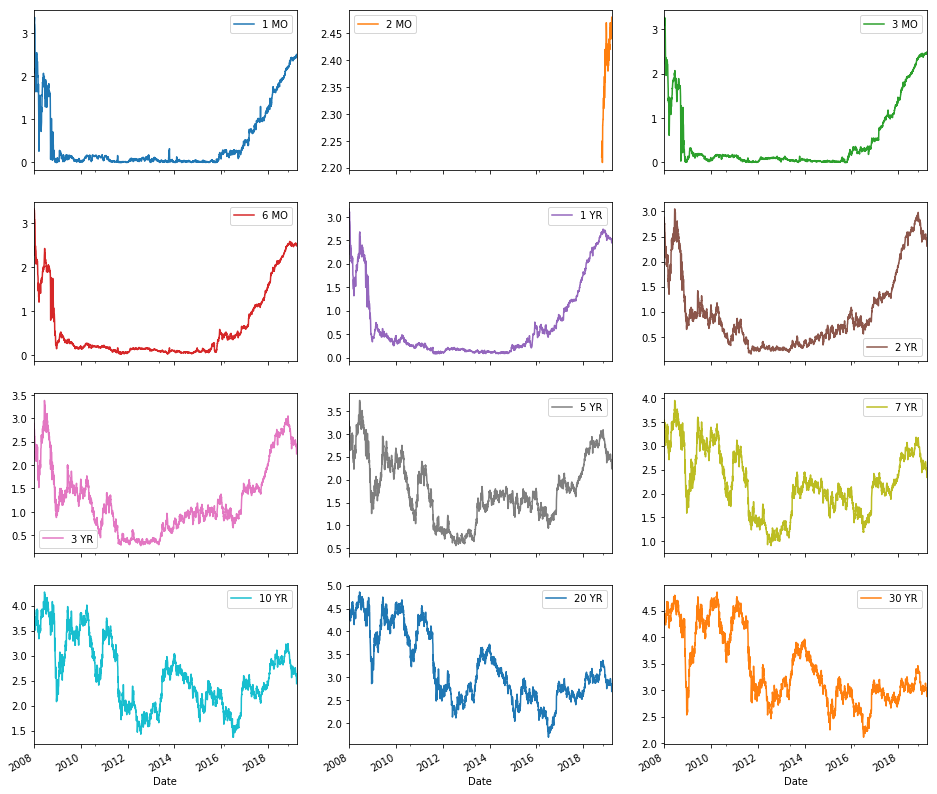

In [15]:
US_treasury_yields.loc[start:].plot(subplots=True, layout=(4,3), figsize=(16, 15))
plt.show();

#### US Treasury yield curves 

In [16]:
TSY3m2y =  US_treasury_yields['2 YR'] - US_treasury_yields['3 MO']
TSY2y10y = US_treasury_yields['10 YR'] - US_treasury_yields['2 YR']

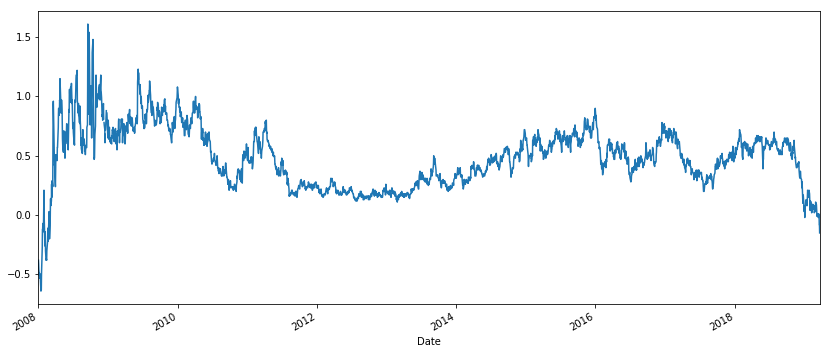

In [17]:
TSY3m2y.loc[start:].plot(figsize=(14, 6))
plt.show();

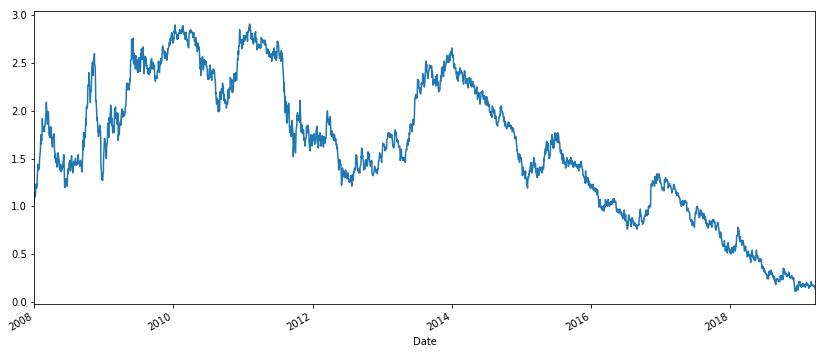

In [18]:
TSY2y10y.loc[start:].plot(figsize=(14, 6))
plt.show();

## German bond yields and curves

### Data sources

#### Create list of bond tenors

In [19]:
tenor = ['6 MO', '1 YR', '2 YR', '5 YR', '7 YR', '10 YR', '20 YR', '30 YR']

#### Import data from Bundesbank website

In [20]:
# creates dictionary where keys represent bond tenors and values are the URL of corresponding dataset
DE = {"DE6 MO_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3210",
      "DE1 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3211",
      "DE2 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3213",
      "DE5 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3219",
      "DE7 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3223",
      "DE10 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3229",
      "DE20 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3449",
      "DE30 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3500"}

### Functions for loading, cleaning and concatenating data

In [21]:
def instrument_names(tenors):
    """
    creates variable names for each instrument, e.g. "DE2y" for a
    2yr German bond and also input variables that will be used in
    subsequent cleaning functions, e.g. DE2y_input
    """
    input_names = [0] * len(tenors)
    
    for i in tenors:
        index = tenors.index(i)
        if index < len(tenors):
            tenors[index] = 'DE'+ i
            input_names[index] = tenors[index] + '_input'
            
    return tenors, input_names

def bunds_clean(URL, tenor):
    """
    Loads and transforms very poorly formatted CSV files with data for each
    bond tenor from German Bundesbank and returns cleaned pandas dataframe
    """
    
    # Use pandas read_csv to download file, if that fails use wget
    try:
        DF = pd.read_csv(URL, sep=';')
    except:
        print("Problem with file download via Pandas read_csv")
        print("==============================================")
        print("Trying with wget instead - will create extra csvs")
        filenumber = tenor[0] + 'a'
        filename = 'bund' + filenumber +'.csv'
        !wget {URL} -O "data/{filename}" -q
        PATH = "data/" + filename
        DF = pd.read_csv(PATH, sep=';')

    assert type(tenor) == str, "Tenor needs to be a string"   
    
    # remove rows without relevant data
    # the first four rows of all files need to be removed the last row 
    # needs to be removed in some files: - tenors 20 YR + 30 YR are fine
    # hence DF[4:] below, but tenors up to 10 YR contain a comment in
    # the last row, which needs to be removed, hence DF[4:-1] for all of those
    
    last_row = DF[-1:].to_string()
    if "Bemerkung" in last_row:
        DF = DF[4:-1]
    else:
        DF = DF[4:]  
        
    # rename columns to give meaningful name
    new_columns = DF.columns.values
    new_columns[0] = 'DATE'
    new_columns[1] = tenor 
    DF.columns = new_columns 
    
    # assign last column to variable 'dropcolumn'
    dropcolumn = DF.columns[2]
    
    # use dropcolumn to remove rows that have missing values (indicated by
    # string in German instead of NaN)
    DF = DF[DF[dropcolumn] != 'Kein Wert vorhanden']
    
    # now remove last column 
    DF = DF.drop([dropcolumn], axis=1)
    
    # reset dataframe index to 0 - was not the case because removed rows earlier
    DF.reset_index(drop=True, inplace=True)
    
    # replace German comma (,) with dot in RATE column
    DF[tenor] = [x.replace(',', '.') for x in DF[tenor]]
    
    # convert RATE column values from string to float
    DF[tenor] = DF[tenor].astype('float')
    
    # convert DATE column values from string to datetime
    DF['DATE'] = pd.to_datetime(DF['DATE'])
    
    # replace dataframe index column with DATE column
    DF.set_index(['DATE'], drop=True, inplace=True)
    
    return DF

def clean_and_join(input_name, tenor):
    """
    Calls bunds_clean function for each input file and concatenates 
    cleaned output into one pandas dataframe, which is returned
    """
    combined = pd.DataFrame() 
    
    for i in range(len(tenor)):
        result = bunds_clean(DE[input_name[i]], tenor[i])
        combined = pd.concat([combined, result], axis=1)
        
    return combined

In [22]:
results = instrument_names(tenor[:])
instruments = results[0]
input_name = results[1]

DE_bond_yields = clean_and_join(input_name, tenor)

DE_bond_yields.to_csv("data/DE_bond_yields.csv")

In [23]:
display(HTML(DE_bond_yields.tail(5).to_html()))

,6 MO,1 YR,2 YR,5 YR,7 YR,10 YR,20 YR,30 YR
DATE,,,,,,,,
2019-03-18,-0.57,-0.58,-0.56,-0.36,-0.19,0.07,0.62,0.78
2019-03-19,-0.57,-0.58,-0.56,-0.36,-0.19,0.07,0.62,0.78
2019-03-20,-0.57,-0.57,-0.54,-0.34,-0.17,0.09,0.63,0.80
2019-03-21,-0.57,-0.57,-0.55,-0.37,-0.20,0.05,0.59,0.75
2019-03-22,-0.58,-0.59,-0.58,-0.41,-0.25,-0.01,0.51,0.67


#### Checking for missing data

In [24]:
#msno.bar(DE_bond_yields.sample(5473), figsize=(8, 3))
#plt.show()

#### Visualising German bond yields for different tenors 

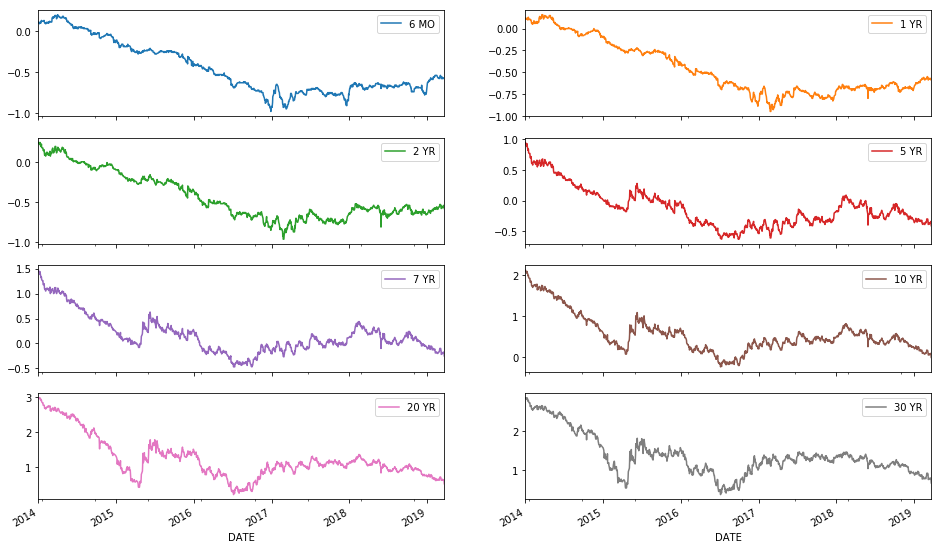

In [25]:
start = '20140101'
end = today
DE_bond_yields.loc[start:].plot(subplots=True, layout=(4,2), figsize=(16, 10))
plt.show();

#### German yield curves

In [26]:
DE2y10y = DE_bond_yields['10 YR'] - DE_bond_yields['2 YR']

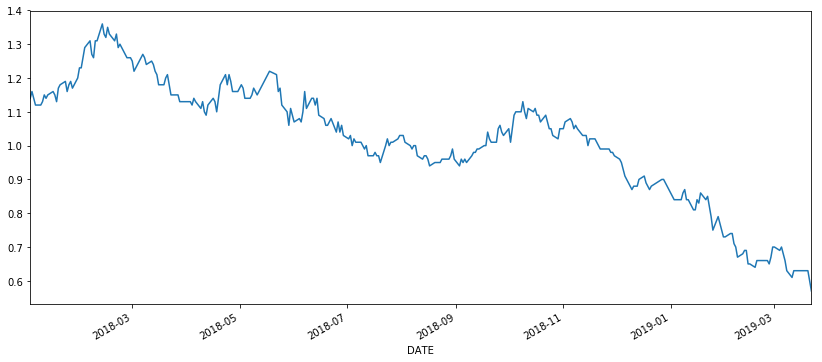

In [27]:
start = '20180101'
DE2y10y.loc[start:].plot(figsize=(14, 6))
plt.show();

In [28]:
# WRITE FUNCTION FOR THIS (and all other data sets)

DE_curve_today = DE_bond_yields.iloc[-1:]
DE_curve_month_ago = DE_bond_yields.iloc[-21:-20]
DE_curve_3month_ago = DE_bond_yields.iloc[-63:-62]
DE_curve_6month_ago = DE_bond_yields.iloc[-126:-125]
DE_curve_year_ago = DE_bond_yields.iloc[-252:-251]

DE_curves_combined = pd.concat([DE_curve_today, DE_curve_month_ago, DE_curve_3month_ago, DE_curve_6month_ago, DE_curve_year_ago])
DE_curves_combined

,6 MO,1 YR,2 YR,5 YR,7 YR,10 YR,20 YR,30 YR
DATE,,,,,,,,
2019-03-22,-0.58,-0.59,-0.58,-0.41,-0.25,-0.01,0.51,0.67
2019-02-22,-0.57,-0.58,-0.57,-0.36,-0.18,0.09,0.64,0.79
2018-12-19,-0.75,-0.68,-0.62,-0.27,-0.03,0.26,0.76,0.94
2018-09-20,-0.64,-0.63,-0.54,-0.12,0.16,0.48,1.01,1.21
2018-03-22,-0.70,-0.70,-0.60,-0.08,0.24,0.58,1.08,1.26


In [29]:
# WRITE FUNCTION FOR THIS (and all other data sets)

DE_diff_today_month_ago = DE_curves_combined.iloc[0] - DE_curves_combined.iloc[1]
DE_diff_today_3month_ago = DE_curves_combined.iloc[0] - DE_curves_combined.iloc[2]
DE_diffs_combined = pd.concat([DE_diff_today_month_ago, DE_diff_today_3month_ago], axis=1)

DE_diffs_combined = DE_diffs_combined.T
DE_diffs_combined.rename({0: "vs 1 MO", 1: "vs 3 MO"}, axis='index', inplace=True)
DE_diffs_combined

,6 MO,1 YR,2 YR,5 YR,7 YR,10 YR,20 YR,30 YR
vs 1 MO,-0.01,-0.01,-0.01,-0.05,-0.07,-0.10,-0.13,-0.12
vs 3 MO,0.17,0.09,0.04,-0.14,-0.22,-0.27,-0.25,-0.27


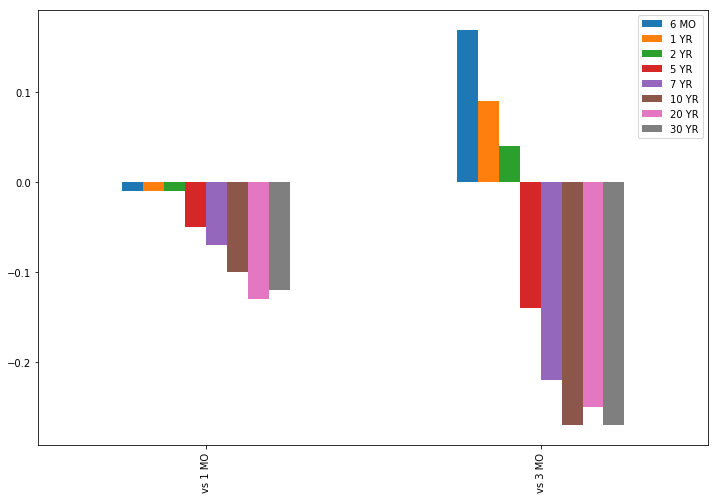

In [30]:
#DE_diffs_combined = pd.DataFrame(data=DE_diffs_combined)
DE_diffs_combined.plot.bar(figsize=(12,8))
plt.show()

## Australian yields

In [31]:
# OZ = pd.read_csv(URL_OZ, encoding='latin-1')  # because of ñ !!!
# big lesson - look at the file before! # show error!!
# conclusion: take excel format - easier here!

# Download via pandas is error-prone, hence try/except procedure which
# uses alternative python command line !wget

URL_OZ = "https://www.rba.gov.au/statistics/tables/xls/f02d.xls"

try:
    OZ_download = pd.read_excel(URL_OZ2, parse_dates=True)
    OZ_download.to_excel("data/OZ.xls")
except:
    print("Problem with download via Pandas read_excel from RBA website")
    print("============================================================")
    print("Trying with wget downloader instead")
    print("============================================================")
    !wget {URL_OZ} -O "data/OZ.xls" -q

# additonal problems may occur i.e. the download may result in an empty file
# if that happens, we take the most recent back-up file

file = Path() / 'data/OZ.xls'  
size = file.stat().st_size

if size == 0:
    OZ_yields = pd.read_excel("data/OZ_backup.xls", parse_dates=True)
else:
    OZ_yields = pd.read_excel("data/OZ.xls", parse_dates=True)
    shutil.copy("data/OZ.xls", "data/OZ_backup.xls")

Problem with download via Pandas read_excel from RBA website
Trying with wget downloader instead


In [32]:
OZ_yields = OZ_yields[10:]

In [33]:
OZ_yields.rename(columns={OZ_yields.columns[0]: "DATE"}, inplace=True)
OZ_yields.set_index(['DATE'], drop=True, inplace=True)

In [34]:
OZ_yields_cl = OZ_yields.rename(columns={OZ_yields.columns[0]: "2 YR", \
                 OZ_yields.columns[1]: "3 YR", OZ_yields.columns[2]: "5 YR", \
                 OZ_yields.columns[3]: "10 YR"})

In [35]:
# remove unneeded columns 
OZ_yields = OZ_yields_cl.drop(OZ_yields.columns[[4, 5, 6, 7]], axis=1)

In [36]:
OZ_yields.tail()

,2 YR,3 YR,5 YR,10 YR
DATE,,,,
2019-03-15,1.595,1.535,1.6,1.98
2019-03-18,1.61,1.55,1.61,1.98
2019-03-19,1.57,1.5,1.565,1.93
2019-03-20,1.55,1.49,1.55,1.935
2019-03-21,1.535,1.465,1.52,1.88


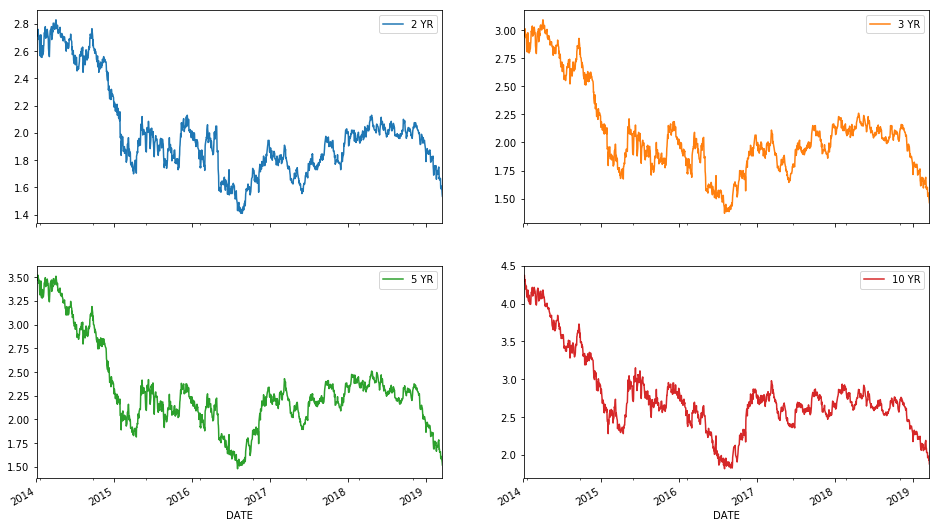

In [37]:
start = '20140101'
end = today
OZ_yields.loc[start:].plot(subplots=True, layout=(4,2), figsize=(16, 20))
plt.show();

## Russian yields

In [38]:
# needs scraping

#https://www.cbr.ru/eng/hd_base/zcyc_params/

## Canada

In [39]:
# . "https://www.bankofcanada.ca/valet/observations/FXCADUSD/csv"
# with Get?


## Japan

In [40]:
# load long-term history and most recent data points 
japan_hist = pd.read_csv("https://www.mof.go.jp/english/jgbs/reference/interest_rate/historical/jgbcme_all.csv",\
                         header=1, parse_dates=['Date'])
japan_current = pd.read_csv("https://www.mof.go.jp/english/jgbs/reference/interest_rate/jgbcme.csv", \
                            header=1, parse_dates=['Date'])

In [41]:
# now likely not needed that parse_dates=['column'] works
# convert date format from separator "/" to "-"
#japan_hist["Date"] = pd.to_datetime(japan_hist["Date"]).dt.strftime('%Y-%m-%d')
#japan_current["Date"] = pd.to_datetime(japan_current["Date"]).dt.strftime('%Y-%m-%d')

In [42]:
# convert those columns in japan_hist that are objects to floats
for col in japan_hist.columns[1:]:
    japan_hist[col] = pd.to_numeric(japan_hist[col], errors='coerce')

In [43]:
# replace index column with date column
japan_hist.set_index(['Date'], drop=True, inplace=True)
japan_current.set_index(['Date'], drop=True, inplace=True)

In [44]:
combined_JGB = pd.concat([japan_hist, japan_current])

In [45]:
# save a copy locally as a CSV
combined_JGB.to_csv("data/JGB_yields.csv")

In [46]:
# check data type of index - it should be datetime
# however parse_dates did not work above in read_csv, so it still is an object
combined_JGB.index

DatetimeIndex(['1974-09-24', '1974-09-25', '1974-09-26', '1974-09-27',
               '1974-09-28', '1974-09-30', '1974-10-01', '1974-10-02',
               '1974-10-03', '1974-10-04',
               ...
               '2019-03-07', '2019-03-08', '2019-03-11', '2019-03-12',
               '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-18',
               '2019-03-19', '2019-03-20'],
              dtype='datetime64[ns]', name='Date', length=11474, freq=None)

In [47]:
# now likely not needed that parse_dates=['column'] works
# convert index to datetime
#combined_JGB.index = pd.to_datetime(combined_JGB.index)

In [48]:
combined_JGB.tail(10)

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,25Y,30Y,40Y
Date,,,,,,,,,,,,,,,
2019-03-07,-0.144,-0.147,-0.152,-0.159,-0.151,-0.151,-0.150,-0.122,-0.067,-0.004,0.230,0.435,0.540,0.624,0.710
2019-03-08,-0.144,-0.147,-0.156,-0.164,-0.154,-0.162,-0.166,-0.141,-0.087,-0.028,0.203,0.405,0.508,0.591,0.674
2019-03-11,-0.145,-0.147,-0.160,-0.165,-0.158,-0.161,-0.162,-0.141,-0.087,-0.030,0.205,0.405,0.505,0.591,0.675
2019-03-12,-0.147,-0.153,-0.163,-0.168,-0.160,-0.166,-0.166,-0.141,-0.086,-0.025,0.211,0.415,0.513,0.598,0.679
2019-03-13,-0.157,-0.158,-0.167,-0.175,-0.170,-0.176,-0.176,-0.151,-0.097,-0.040,0.195,0.401,0.498,0.582,0.656
2019-03-14,-0.158,-0.163,-0.168,-0.175,-0.170,-0.177,-0.176,-0.151,-0.096,-0.033,0.195,0.402,0.498,0.577,0.652
2019-03-15,-0.160,-0.165,-0.168,-0.175,-0.171,-0.177,-0.171,-0.146,-0.091,-0.028,0.201,0.407,0.503,0.582,0.656
2019-03-18,-0.161,-0.161,-0.169,-0.173,-0.171,-0.176,-0.171,-0.146,-0.090,-0.028,0.201,0.407,0.507,0.587,0.661
2019-03-19,-0.162,-0.161,-0.169,-0.174,-0.171,-0.176,-0.179,-0.151,-0.096,-0.037,0.190,0.393,0.491,0.567,0.638


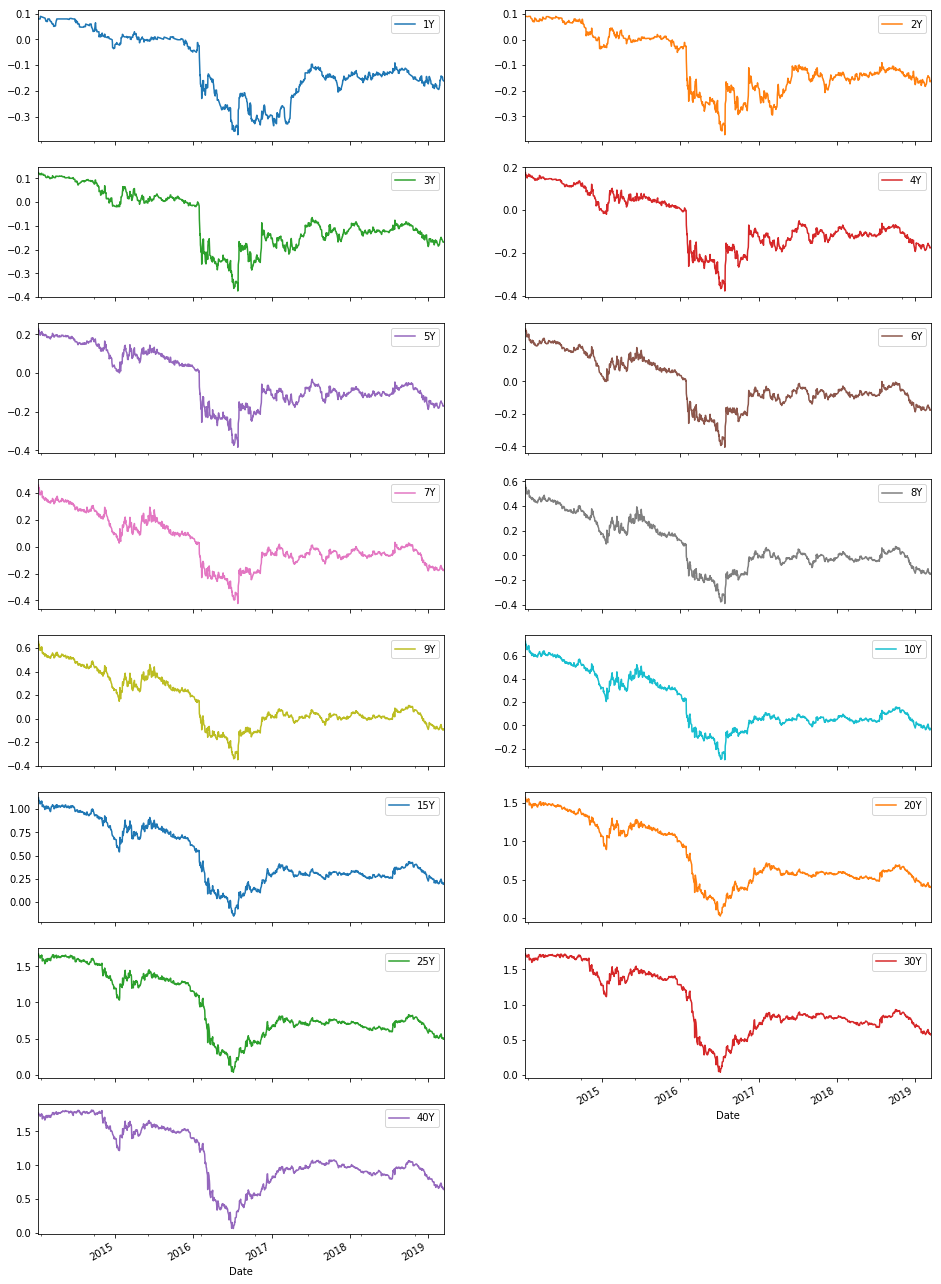

In [49]:
start = '20140101'
#start = datetime.datetime(2008, 1, 1)
end = today
combined_JGB[start:].plot(subplots=True, layout=(8,2), figsize=(16, 25))
plt.show();

#### Todo

In [50]:
# Write function for DE yield curves

#def generate_yieldcurves:

#DE_yield_curve = pd.DataFrame()
#DE_yield_curve['2y10y'] =  DE_bond_yields.apply(lambda x: x['10y'] - x['2y'], axis=1)

#def clean_and_join(input_name, tenor):
#    """
#    """
#    combined = pd.DataFrame() 
#    for i in range(len(tenor)):
#        result = bunds_clean(DE[input_name[i]], tenor[i])
#        combined = pd.concat([combined, result], axis=1)
#    return combined